In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
words = open('/content/name.txt','r').read().splitlines()
print(len(words))
print(max(len(w) for w in words))
print(words[:10])

32033
15
['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia', 'harper', 'evelyn']


In [3]:
# build the vocabulary of characters and mapping to/from integers

chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {i:s for s,i in stoi.items()}
vocab_size = len(itos)
print(itos)
print(vocab_size)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}
27


In [4]:
# shuff up the words
import random
random.seed(42)
random.shuffle(words)

In [24]:
# build the data set
block_size =8

def build_dataset(words):
  X,Y = [],[]
  for w in words:
    context = [0]*block_size
    for ch in w + '.':
      ix = stoi[ch]
      X.append(context)
      Y.append(ix)
      # print(''.join(itos[i] for i in context), '----->',itos[ix])
      context = context[1:] + [ix]
  X = torch.tensor(X)
  Y = torch.tensor(Y)
  print(X.shape,Y.shape)
  return X.to(device),Y.to(device)

n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr,Ytr = build_dataset(words[:n1])
Xdev,Ydev = build_dataset(words[n1:n2])
Xte,Yte = build_dataset(words[n2:])

torch.Size([182625, 8]) torch.Size([182625])
torch.Size([22655, 8]) torch.Size([22655])
torch.Size([22866, 8]) torch.Size([22866])


In [6]:
for x,y in zip(Xtr[:20],Ytr[:20]):
  print(''.join(itos[ix.item()] for ix in x), '----->', itos[y.item()])

........ -----> y
.......y -----> u
......yu -----> h
.....yuh -----> e
....yuhe -----> n
...yuhen -----> g
..yuheng -----> .
........ -----> d
.......d -----> i
......di -----> o
.....dio -----> n
....dion -----> d
...diond -----> r
..diondr -----> e
.diondre -----> .
........ -----> x
.......x -----> a
......xa -----> v
.....xav -----> i
....xavi -----> e


In [14]:
# Copy from the part 3

# ----------------------------------------------

class Linear:
  def __init__(self,fan_in,fan_out,bias=True) -> None:
    self.weight = torch.randn((fan_in,fan_out)) / fan_in**0.5
    self.bias = torch.zeros(fan_out) if bias else None

  def __call__(self,x):
    self.out = x@self.weight
    if self.bias is not None:
      self.out += self.bias
    return self.out

  def parameters(self):
    return [self.weight] + ([] if self.bias is None else [self.bias])

# ----------------------------------------------
class BatchNormld:
    def __init__(self,dim,eps=1e-5,momentum=0.1) -> None:
      self.eps = eps
      self.momentum = momentum
      self.training = True
      # parameters (trained with backprop)
      self.gamma = torch.ones(dim)
      self.beta = torch.zeros(dim)
      # buffers (trained with a running 'momentum update')
      self.running_mean = torch.zeros(dim)
      self.running_var = torch.ones(dim)

    def __call__(self, x):
      # calculate the forward pass
      if self.training:
        if x.ndim == 2:
          dim = 0
        elif x.ndim == 3:
          dim = (0,1)
        xmean = x.mean(dim, keepdim=True) # batch mean
        xvar = x.var(dim, keepdim=True) # batch variance

      else:
        xmean = self.running_mean
        xvar = self.running_var
      xhat = (x - xmean) / torch.sqrt(xvar + self.eps) # normalize to unit variance
      self.out = self.gamma * xhat + self.beta
      # update the buffers
      if self.training:
        with torch.no_grad():
          self.running_mean = (1 - self.momentum) * self.running_mean + self.momentum * xmean
          self.running_var = (1 - self.momentum) * self.running_var + self.momentum * xvar
      return self.out

    def parameters(self):
      return [self.gamma, self.beta]

# ----------------------------------------------
class Tanh:
  def __call__(self, x):
    self.out = torch.tanh(x)
    return self.out
  def parameters(self):
    return []

# ----------------------------------------------
class Embedding:
  def __init__(self,num_embeddings,embedding_dim) -> None:
    self.weight = torch.randn((num_embeddings,embedding_dim))

  def __call__(self, IX):
    self.out = self.weight[IX]
    return self.out

  def parameters(self):
    return [self.weight]

  # ----------------------------------------------
class FlattenConsecutive:

    def __init__(self,n):
      self.n = n


    def __call__(self,x):
      B,T,C = x.shape
      x = x.view(B,T//self.n,C*self.n)
      if x.shape[1] == 1:
        x = x.squeeze(1)

      self.out = x
      return self.out

    def parameters(self):
      return []
  # ----------------------------------------------
class Sequential:
    def __init__(self,layers) -> None:
      self.layers = layers

    def __call__(self,x):
      for layer in self.layers:
        x = layer(x)
      self.out = x
      return self.out

    def parameters(self):
      return [p for layer in self.layers for p in layer.parameters()]

    def to(self, device):
      for layer in self.layers:
        # For layers with 'weight' and 'bias' attributes (like Linear, Embedding)
        if hasattr(layer, 'weight'):
          layer.weight = layer.weight.to(device)
        if hasattr(layer, 'bias') and layer.bias is not None:
          layer.bias = layer.bias.to(device)
        # For BatchNormld specific parameters and buffers
        if isinstance(layer, BatchNormld):
          layer.gamma = layer.gamma.to(device)
          layer.beta = layer.beta.to(device)
          layer.running_mean = layer.running_mean.to(device)
          layer.running_var = layer.running_var.to(device)
      return self

In [8]:
torch.manual_seed(42);
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [15]:
# ----------------------------------------------
n_embd = 24
n_hidden = 128

model  = Sequential([
    Embedding(vocab_size, n_embd),
    FlattenConsecutive(2),Linear(n_embd * 2, n_hidden,bias=False), BatchNormld(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden,bias=False), BatchNormld(n_hidden), Tanh(),
    FlattenConsecutive(2),Linear(n_hidden * 2, n_hidden,bias=False), BatchNormld(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size),
])

model.to(device)

# parameter init
with torch.no_grad():
  # last layer: make less confident
  model.layers[-1].weight *= 0.1


parameters =model.parameters()
print(sum(p.nelement() for p in parameters))
for p in parameters:
  p.requires_grad = True

76579


In [16]:
ix = torch.randint(0, Xtr.shape[0], (4,))
Xb, Yb = Xtr[ix], Ytr[ix]
logits = model(Xb)
print(Xb.shape)
Xb

torch.Size([4, 8])


tensor([[ 0,  0, 19,  1, 25, 12,  1,  8],
        [ 0,  0,  0,  0,  0, 25, 22,  5],
        [ 0,  0,  0,  5, 13, 13,  1, 14],
        [ 0,  0,  0,  0,  0, 11, 25,  5]])

In [17]:
for layer in model.layers:
  print(layer.__class__.__name__,':',tuple(layer.out.shape))

Embedding : (4, 8, 24)
FlattenConsecutive : (4, 4, 48)
Linear : (4, 4, 128)
BatchNormld : (4, 4, 128)
Tanh : (4, 4, 128)
FlattenConsecutive : (4, 2, 256)
Linear : (4, 2, 128)
BatchNormld : (4, 2, 128)
Tanh : (4, 2, 128)
FlattenConsecutive : (4, 256)
Linear : (4, 128)
BatchNormld : (4, 128)
Tanh : (4, 128)
Linear : (4, 27)


In [18]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 128])

In [25]:
# same optimization as last time
max_steps = 200000
batch_size = 32
lossi = []

for i in range(max_steps):

  # minibatch construct
  ix = torch.randint(0, Xtr.shape[0], (batch_size,), device=device)
  Xb,Yb = Xtr[ix].to(device), Ytr[ix].to(device)

  # forward pass
  logits = model(Xb)
  loss = F.cross_entropy(logits, Yb)

  # backward pass
  for p in parameters:
      p.grad = None
  loss.backward()

  # update
  lr = 0.1 if i < 150000 else 0.01
  for p in parameters:
    p.data += -lr * p.grad

  # track stats
  if i % 10000 == 0:
    print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
  lossi.append(loss.log10().item())

      0/ 200000: 3.2990
  10000/ 200000: 1.7531
  20000/ 200000: 1.6683
  30000/ 200000: 2.6054
  40000/ 200000: 1.9674
  50000/ 200000: 1.9814
  60000/ 200000: 2.2007
  70000/ 200000: 2.2626
  80000/ 200000: 1.9678
  90000/ 200000: 1.9223
 100000/ 200000: 1.7621
 110000/ 200000: 1.8600
 120000/ 200000: 2.1208
 130000/ 200000: 1.9859
 140000/ 200000: 1.7544
 150000/ 200000: 1.7988
 160000/ 200000: 1.7976
 170000/ 200000: 1.7215
 180000/ 200000: 1.1486
 190000/ 200000: 1.8266


Learning Rate Decay

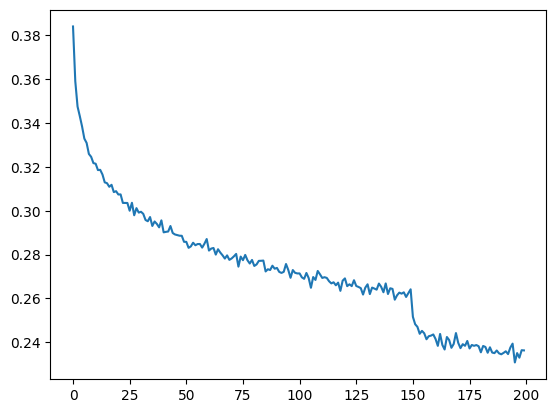

In [26]:
plt.plot(torch.tensor(lossi).view(-1,1000).mean(1))

In [27]:
for layer in model.layers:
  layer.training = False

In [28]:
@torch.no_grad() # this decorator disable gradient tracking
def split_loss(split):
  x,y = {
    'train': (Xtr, Ytr),
    'val': (Xdev, Ydev),
    'test': (Xte, Yte),
  }[split]
  logits = model(x.to(device))
  loss = F.cross_entropy(logits, y.to(device))
  print(split, loss.item())

split_loss('train')
split_loss('val')

train 1.734610676765442
val 2.0329647064208984


In [29]:
# sample from the model

for _ in range(20):

  out = []
  context = [0] * block_size # initialize with all ...
  while True:
    # forward pass the neural net
    logits = model(torch.tensor([context]).to(device))
    probs = F.softmax(logits, dim=1)
    # sample from the distribution
    ix = torch.multinomial(probs, num_samples=1).item()
    # shift the context window and track the samples
    context = context[1:] + [ix]
    out.append(ix)
    # if we sample the special '.' token, break
    if ix == 0:
      break

  print(''.join(itos[i] for i in out))

reginga.
tahmion.
matji.
stevan.
larisah.
shajana.
laiken.
aziyah.
jalani.
vano.
keagyn.
briell.
seip.
paisley.
emanuelle.
graeshaun.
akshane.
kelly.
charbel.
dannell.
